In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
!pip install -q -U tensorflow-addons umap-learn
!pip install tensorflow_datasets
!pip install -q -U tensorflow-addons
!pip install opencv-python
!pip install os
!pip install pillow

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
import os
gent=os.listdir('/kaggle/input/cedardataset/signatures/full_org')
forgt=os.listdir('/kaggle/input/cedardataset/signatures/full_forg')
#print(gent)

In [6]:
from tqdm.notebook import tqdm 
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import umap 
from skimage.filters import  threshold_otsu
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [8]:
## images in CEDAR are prefixed by the number/index of the signer, and if forgery or genuine. 
## we will assign class names genuince and forgeries for each signature
signer_range = range(0,55)
class_name1 = [ "s" +str(x) for x in signer_range] # class names for genuine signatures s1 - s55
class_name2 = [ "frg" +str(x) for x in signer_range] # classnames  for forgeries frg1 -frg55
class_names = class_name1 + class_name2

# We will assign 11 signatures manually to a hold out test set
hold_out_1 = [ 2,  7,  8,  9, 15, 16, 18, 35, 41, 44, 48] ## prefix sor held out genuine signatures
hold_out_2 = [x+55 for x in hold_out_1] ## prefix for held out forged signatures
hold_out = hold_out_1 + hold_out_2 
print(hold_out)
print(class_names)

[2, 7, 8, 9, 15, 16, 18, 35, 41, 44, 48, 57, 62, 63, 64, 70, 71, 73, 90, 96, 99, 103]
['s0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45', 's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54', 'frg0', 'frg1', 'frg2', 'frg3', 'frg4', 'frg5', 'frg6', 'frg7', 'frg8', 'frg9', 'frg10', 'frg11', 'frg12', 'frg13', 'frg14', 'frg15', 'frg16', 'frg17', 'frg18', 'frg19', 'frg20', 'frg21', 'frg22', 'frg23', 'frg24', 'frg25', 'frg26', 'frg27', 'frg28', 'frg29', 'frg30', 'frg31', 'frg32', 'frg33', 'frg34', 'frg35', 'frg36', 'frg37', 'frg38', 'frg39', 'frg40', 'frg41', 'frg42', 'frg43', 'frg44', 'frg45', 'frg46', 'frg47', 'frg48', 'frg49', 'frg50', 'frg51', 'frg52', 'frg53', 'frg54']


In [18]:
#img_target_size = (250, 250)
img_target_size = (224, 224)
data_base_path = "/kaggle/input/cedardataset/signatures" 
def generate_dataset(): 
    x_train, y_train = [], []  
    x_test, y_test = [], [] 
    for i in tqdm(range(1,56)): 
        for j in range(1,25): 
            orig_img_path =  "/full_org/original_" + str(i) + "_" + str(j) + ".png"  
            if (i not in hold_out):
                x_train.append(orig_img_path)
                y_train.append(i)
            else:
                x_test.append(orig_img_path )
                y_test.append(i)

    for i in tqdm(range(1,56)): 
        for j in range(1,25):
            forg_img_path =  "/full_forg/forgeries_" + str(i) + "_" + str(j) + ".png"  
            if ((i+55) not in hold_out):
                x_train.append(forg_img_path)
                y_train.append(i+55)
            else:
                x_test.append(forg_img_path)
                y_test.append(i+55)
    return (x_train), (y_train), (x_test), (y_test)

In [11]:
x_train, y_train, x_test, y_test = generate_dataset()

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

In [12]:
import pandas as pd
pd.DataFrame(zip(x_train, y_train))
pd.DataFrame(zip(x_test, y_test))

,0,1
0,/full_org/original_2_1.png,2
1,/full_org/original_2_2.png,2
2,/full_org/original_2_3.png,2
3,/full_org/original_2_4.png,2
4,/full_org/original_2_5.png,2
...,...,...
523,/full_forg/forgeries_48_20.png,103
524,/full_forg/forgeries_48_21.png,103
525,/full_forg/forgeries_48_22.png,103
526,/full_forg/forgeries_48_23.png,103


In [19]:
a=[]
b=[]
def threshold_image(img_arr):
    thresh = threshold_otsu(img_arr)
    if(img_arr > thresh,255,0):  #it compares each and every pixel value of n*n array and for every image there is some threshold if that image every pixel above it's thresho;d then it is consider else not
        k=img_arr.min()
    #b.append(int(float(k)))
    #a.append(float(thresh))
  
    return np.where(img_arr > thresh, 255, 0) #here we are setting if value in img_arr is greater than threshold value then it is assign as 255 else it is assign as 0
def load_data(img_paths):
    results = []
    for img_path in img_paths:
        img_np = load_img(data_base_path + str(img_path ), target_size=img_target_size )
        img_np = np.squeeze(img_to_array(img_np))  
        img_np = threshold_image(img_np) 
        img_np = img_np * (1./255) #here we are converting/normalizing img arry to 0 and 1 form by dividing with 255
        results.append(img_np) 
    return np.array(results)

In [20]:
batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1024, seed=123).batch(batch_size) 
val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size) 

def generate_pair(x,y):    
    x = [x.decode("utf-8") for x in x.numpy()]
    x = load_data(x)  
    return x,y

train_ds = train_ds.map(lambda x, y: tf.py_function(generate_pair, [x,y], [tf.float32,tf.int32]))
val_ds = val_ds.map(lambda x, y: tf.py_function(generate_pair, [x,y], [tf.float32,tf.int32])) 

In [ ]:
#for i in x_train:
 # print(i)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (224, 224, 3) looks like that of an RGB image.
  after removing the cwd from sys.path.


tf.Tensor(
[26 20  1  1 40 29 53 27 33 30 24 32 24 42 42 51  5 47 21 26 27 45 38 13
 22 24  6 49 32 45 49 33 14 10  3 39  5 17 17  5 19 42 45 28 36 32 34 13
 22 25 33 25 49 29 23 42 34 20 34  1 17 51 42 21 20 13 23 21 50  6 45 56
 31  6  1 28 36 56 47 45 10 45 25 33 46 52 47 12 50 21 58 45 52 20 20 53
 20 33 45  1 14 33 45 53 22 11 42 53 55 25 19 34  3 28 10 27 28 59 38 33
 25 51 31 49  5 36 23 27], shape=(128,), dtype=int32)


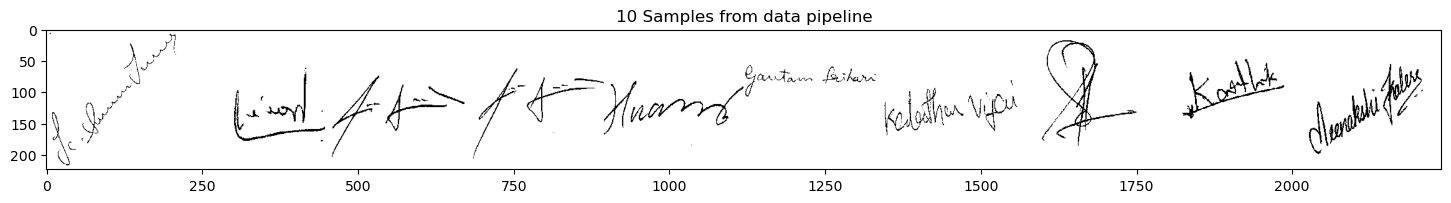

In [21]:
mini=255
for x, y in train_ds.take(1):
    n=10
    plt.figure(figsize=(18,6))
    plt.imshow(np.concatenate([j for j in x[:n]], axis=1)); 
    print(y)
plt.title(f"{n} Samples from data pipeline");
#thresh = threshold_otsu(p)
sum=0
#for i in a:
#  sum+=float(i)
#for i in b:
#  mini=min(mini,int(float(i)))
#n=len(a)
#if(n>0):
#  print(sum/n)
#  print(mini)
#minimum threshold value is 55

In [22]:
# we can use caching and prefetching to improve performance 
# https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [24]:
#build and train model
input_shape =(224,224,3)
#input_shape =(250,250,3)
from tensorflow.keras import layers, models, losses, optimizers, metrics
from tensorflow import keras 
from tensorflow.keras.models import Model
from tensorflow.keras.backend import int_shape
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Input, concatenate, Cropping2D
from tensorflow.keras.applications import  resnet, VGG16, EfficientNetB3
 
def conv2d_block(inputs, dropout=0.2,filters=16, kernel_size=(3, 3), padding="same"):
    c = Conv2D( filters,kernel_size,activation="relu",kernel_initializer="he_normal",padding="same", use_bias=False)(inputs)
    if dropout > 0.0:
        c = Dropout(dropout)(c)
        c = Conv2D( filters,kernel_size,activation="relu",kernel_initializer="he_normal",padding="same", use_bias=False)(c)
    return c
 
def attach_head(model, normalize_output=True):
#     x = Conv2D(filters=64, kernel_size=3, name="conv3", padding='same')(model.output)
    x = conv2d_block(model.output, filters=64)
    x = MaxPooling2D(pool_size=2)(x)
#     x = Conv2D(filters=32, kernel_size=3,  name="conv4" , padding='same')(x)
    x = conv2d_block(x, filters=32)
    x = MaxPooling2D(pool_size=2)(x) 
    flatten = layers.Flatten()(x) 
    output = layers.Dense(256, activation=None)(flatten)
    # l2 normalization constrains the embeddings to lie on a hypersphere https://stats.stackexchange.com/questions/248511/purpose-of-l2-normalization-for-triplet-network
    output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output) # L2 normalize embeddings
    embedding = Model(model.input, output, name="Embedding")
    return embedding

def full_resnet(input_shape, normalize_output=True):
    base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=input_shape, include_top=False
  )
    return attach_head(base_cnn, normalize_output=normalize_output)

def small_resnet(input_shape, layer_name="conv4_block6_add",scratch=False): 
    base_model = resnet.ResNet50(
      weights="imagenet", input_shape=input_shape, include_top=scratch
    )    
    base_cnn = Model( inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)  
    return attach_head(base_cnn)

def small_vgg(input_shape): 
    base_model = VGG16(
      weights="imagenet", input_shape=input_shape, include_top=False
    ) 
    base_cnn = Model( inputs=base_model.input, outputs=base_model.get_layer("block3_conv1").output) 
    return attach_head(base_cnn)

In [25]:
all_model_details = [
                 {"name":"small_resnet_scratch", "model": small_resnet(input_shape, scratch=True)},
                #  {"name":"small_resnet_scratch_nonorm", "model": small_resnet_scratch(input_shape, normalize_output=False)}, 
                # {"name":"small_vgg", "model": small_vgg(input_shape)},  
                 #{"name":"small_resnet", "model": small_resnet(input_shape)},
                ##  {"name":"small_resnet_nonorm", "model": small_resnet(input_shape, "conv4_block6_3_conv", normalize_output=False)},
] 

102967424/102967424 [==============================] - 1s 0us/step


In [26]:
 def plot_history(history, title=""):  
  # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Losss | ' + title)
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

In [28]:
initial_learning_rate = 0.00001
#initial_learning_rate = 0.0001
steps_per_epoch = int(len(x_train)/batch_size)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps= steps_per_epoch*2,
    decay_rate=0.80,
    staircase=False)
print(f"Steps per epoch {steps_per_epoch}")

Steps per epoch 16


In [30]:
from time import time

def train_models():
    trained_models = []
    for model_detail in all_model_details: 
        model, name = model_detail["model"], model_detail["name"]
        print("Training model >> ", name)
        model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss=tfa.losses.TripletSemiHardLoss(margin = 0.8)) 
        start_time = time()
        history = model.fit(
        train_ds,
        #epochs = 20,
        epochs = 16,
        validation_data = val_ds)
    elapsed_time = time() - start_time
    plot_history(history, title= " Triplet Loss - " + name ) 
    # save_model(name, model)
    trained_models.append({"name":name,"model": model, "time": elapsed_time, "history":history.history} )
    return trained_models
#it is run on:->metrics=[tf.keras.metrics.CategoricalAccuracy()]
#metrics=[tf.keras.metrics.Accuracy()]
    #val_loss, val_acc = model.evaluate(val_ds)
    #print(val_acc)
    # save_model(name, model)
    

Training model >>  small_resnet_scratch
Epoch 1/16


2023-05-03 07:23:28.230614: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEmbedding/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (224, 224, 3) looks like that of an RGB image.
  after removing the cwd from sys.path.


17/17 [==============================] - 67s 2s/step - loss: 0.7979 - val_loss: 0.7921
Epoch 2/16
17/17 [==============================] - 26s 1s/step - loss: 0.7960 - val_loss: 0.7944
Epoch 3/16
17/17 [==============================] - 32s 2s/step - loss: 0.7951 - val_loss: 0.7963
Epoch 4/16
17/17 [==============================] - 32s 2s/step - loss: 0.7925 - val_loss: 0.7965
Epoch 5/16
17/17 [==============================] - 27s 2s/step - loss: 0.7907 - val_loss: 0.7964
Epoch 6/16
17/17 [==============================] - 26s 2s/step - loss: 0.7896 - val_loss: 0.7964
Epoch 7/16
17/17 [==============================] - 27s 2s/step - loss: 0.7878 - val_loss: 0.7961
Epoch 8/16
17/17 [==============================] - 31s 2s/step - loss: 0.7863 - val_loss: 0.7957
Epoch 9/16
17/17 [==============================] - 28s 2s/step - loss: 0.7847 - val_loss: 0.7956
Epoch 10/16
17/17 [==============================] - 25s 1s/step - loss: 0.7845 - val_loss: 0.7955
Epoch 11/16
17/17 [===========

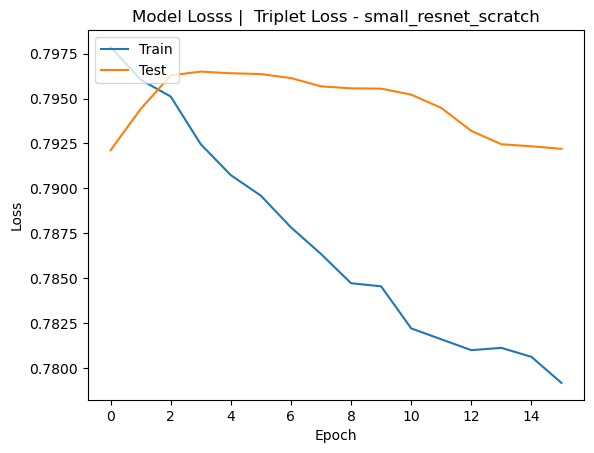

In [31]:
trained_models = train_models()
!mkdir -p saved_model
#print(trained_models)

trained_models[0]['model'].save('/kaggle/working/')

# New Section

In [32]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/my_model')

# Check its architecture
new_model.summary()

OSError: No file or directory found at /content/drive/My Drive/my_model

In [33]:
y_pred=[]
import plotly.express as px
def plot_features(model, title="UMAP Embedding Projection", metric="euclidean"):
    test_features = model.predict(val_ds)
    y_pred.append(test_features)
    print("Compute UMAP for vector with shape", test_features.shape, " metric:", metric)
    reducer = umap.UMAP(n_neighbors=15, n_components=2, metric=metric)
    embedding = reducer.fit_transform(test_features)

    colors = [ x for x in y_test] 
    acm = [class_names[x] for x in colors]

    fig = px.scatter(
      x=embedding[:, 0],
      y=embedding[:, 1],
      color=acm,
      opacity=0.5,
      hover_name=acm,
      # symbol=acm,
      width=800,
      height=600,
      title=title,
      )
    fig.show() 

In [35]:
#this has been used instead of next code cell if model's runtime is break
plot_features(new_model,title="small_resnet_sratch")

NameError: name 'new_model' is not defined

In [36]:
for model_detail in trained_models:
    model = model_detail["model"]
    plot_features(model, title=model_detail["name"] )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (224, 224, 3) looks like that of an RGB image.
  after removing the cwd from sys.path.


5/5 [==============================] - 6s 916ms/step
Compute UMAP for vector with shape (528, 256)  metric: euclidean


In [37]:
y_true=[]
cnt=0
total=0
l_p=len(y_pred)
for x,y in val_ds:
    y_true.append(y)
#print(y_test)
print(y_true[0].shape)
print(y_pred[0].shape)
l_t=len(y_true)
iter=0
print(y_pred[0][0])
for val in y_true:
    x_list = val.numpy().tolist()
    for i in range(len(x_list)):
        if(y_pred[0][0][i]==x_list[i]):
            cnt+=1
        total+=1
#for i in range(128):
#    print(y_true[0][i])
        
#print(cnt)
#print(total)

    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning:

threshold_otsu is expected to work correctly only for grayscale images; image shape (224, 224, 3) looks like that of an RGB image.



(128,)
(528, 256)
[ 0.01234784  0.11235182  0.03135654 -0.03715093  0.09395011  0.14180465
  0.01099354 -0.07250354  0.05055339 -0.01205469  0.07586987 -0.03723396
  0.1271129  -0.01244524 -0.07391074  0.00545797 -0.0490327   0.01655281
  0.07387448 -0.05707895 -0.04490956 -0.09876574  0.02141671  0.05350649
 -0.01356393 -0.02047037 -0.01385461  0.04115763  0.07415654 -0.1044943
 -0.04202496  0.02779912 -0.03635289  0.01354592 -0.06423049  0.0336882
  0.08745112 -0.04311375 -0.14332189 -0.05285208 -0.03658754  0.00693116
 -0.05327155  0.05923892 -0.05479654 -0.06282192  0.04185426  0.00295198
 -0.01360757 -0.01609993  0.08780818 -0.10243509 -0.02477241  0.0758647
  0.04981206  0.0576703   0.01535474 -0.0711064   0.02476963 -0.13550395
  0.01836131 -0.07569032  0.03571     0.00466676 -0.0772484  -0.05502913
 -0.05404663  0.07023853 -0.02608356 -0.0983227   0.07392293 -0.01590606
  0.07200581 -0.0105684   0.00941652  0.00936313  0.00912411  0.08391239
  0.05342945 -0.00165642  0.06201562

In [39]:
import itertools
import random

hold_out_comb = list(itertools.combinations(hold_out_1, 2)) 
r24 = range(1,25)
comb_24 = list(itertools.combinations(r24, 2))

In [41]:
positive_pairs = []
for i in hold_out_1:
    for (a,b) in comb_24:
        a= orig_img_path =f"/full_org/original_{i}_{a}.png" 
        b= orig_img_path =f"/full_org/original_{i}_{b}.png"   
        positive_pairs.append([a,b])

# easy negatives 
easy_negs = []
for (i,j) in hold_out_comb:
    for (a,b) in comb_24:
        a= orig_img_path =f"/full_org/original_{i}_{a}.png" 
        b= orig_img_path =f"/full_org/original_{j}_{b}.png"   
        easy_negs.append([a,b])     

# hard negatives
hard_negs = []
for c in hold_out_1:
    for i in range(1,25): 
        for j in range(1,25): 
            a= orig_img_path =f"/full_org/original_{c}_{i}.png" 
            b= orig_img_path =f"/full_forg/forgeries_{c}_{j}.png"   
            hard_negs.append([a,b])  

In [42]:
print( f"{len(positive_pairs)} positive pairs, {len(hard_negs)} hard negatives, {len(easy_negs)} easy negatives" )
# downsample hard negative and easy negative
easy_negs = random.sample(easy_negs, len(positive_pairs))
hard_negs = random.sample(hard_negs, len(positive_pairs)) 
print( f"Downsampled: {len(positive_pairs)} positive pairs, {len(hard_negs)} hard negatives, {len(easy_negs)} easy negatives" )

3036 positive pairs, 6336 hard negatives, 15180 easy negatives
Downsampled: 3036 positive pairs, 3036 hard negatives, 3036 easy negatives


In [45]:
#finding accuracy using confusion metric etc
#p_triplet=len(positive_pairs)
#total_triplet=len(positive_pairs)+len(hard_negs)+len(easy_negs)
#accuracy=1-(len(positive_pairs)/(total_triplet))
#print("accuracy : ",accuracy)

In [43]:
#Create Datasets for Prediction
AUTOTUNE = tf.data.AUTOTUNE

def generate_pair_data(x):    
    x = [x.decode("utf-8") for x in x.numpy()]
    x = load_data(x)  
    return x

def get_pair_ds(x, batch_size): 
    ds = tf.data.Dataset.from_tensor_slices(x).batch(batch_size)   
    ds = ds.map(lambda x: tf.py_function(generate_pair_data, [x], tf.float32)) 
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def get_pair_distance(pair, model, batch_size=64):
    a_ds = get_pair_ds([x[0] for x in pair], batch_size=batch_size)
    b_ds = get_pair_ds([x[1] for x in pair], batch_size=batch_size) 
    a_preds = model.predict(a_ds)
    b_preds = model.predict(b_ds)
    distances = tf.reduce_sum(tf.multiply(a_preds,b_preds), axis=1) 
    return distances

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning:

threshold_otsu is expected to work correctly only for grayscale images; image shape (224, 224, 3) looks like that of an RGB image.



48/48 [==============================] - 25s 528ms/step
tf.Tensor([0.9368047  0.9913384  0.99384314 ... 0.99236953 0.9784638  0.9831076 ], shape=(3036,), dtype=float32)
tf.Tensor([0.97204304 0.97206366 0.9793451  ... 0.9829694  0.9438913  0.9869908 ], shape=(3036,), dtype=float32)


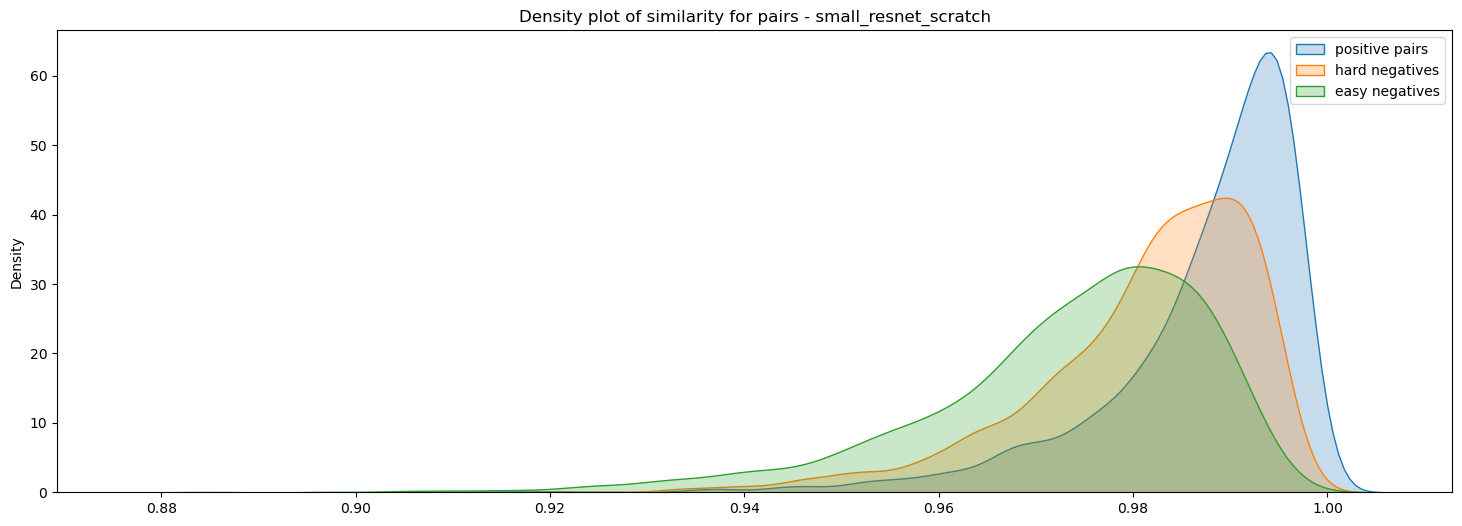

In [44]:
#to run this we have to first comment the a and b in load function ,here a and b we are using to find threshold value so that we are able to calcuclate acccuracy etc 
#so when we are using that then we will not plt seaborn plot for hard neg and easy neg and positive dist graph
import seaborn as sns 

for model_detail in trained_models:
    model = model_detail["model"]
    easy_neg_dist = get_pair_distance(easy_negs, model, batch_size=64)
    hard_neg_dist = get_pair_distance(hard_negs, model, batch_size=64)
    positive_dist = get_pair_distance(positive_pairs, model, batch_size=64)
    print(positive_dist)
    print(easy_neg_dist)
    plt.figure(figsize=(18,6)) 
    sns.kdeplot(positive_dist, label="positive pairs ", fill=True);
    sns.kdeplot(hard_neg_dist, label="hard negatives", fill=True);
    sns.kdeplot(easy_neg_dist, label="easy negatives", fill=True);
    plt.legend();
    plt.title(f"Density plot of similarity for pairs - {model_detail['name']}");
    plt.show()

In [46]:
pos=[]
neg=[]
fav=0
tot=0
for i in positive_dist:
    pos.append(i)
#for i in positive_dist:
#    pos.append(i)
for i in easy_neg_dist:
    neg.append(i)
#for i in hard_neg_dist:
#    neg.append(i)
for i in range(len(pos)):
    if(pos[i]>neg[i]):
        fav+=1
    tot+=1
accuracy=fav/tot
print("accuracy : ",accuracy)

accuracy :  0.819828722002635
